<h1> ______________________________________ </h1>

<h1> Time and Energy resolution calculation </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we calculate the energy and time resolution of our photosensor (SiPM Hamamatsu in this case) the following way:</p>

- <p style="font-size: 17px; color: black; font-weight: bold;"> Time resolution: </p> 
<p style="font-size: 17px; color: black;"> We set a voltage threshold and we measure the time difference between when our signal and our trigger waveform pass that threshold. The std of that time difference distribution will be our time resolution. The time resolution is not the same for all signals so we differenciate among signals of 1pe, 2pe, 3pe, etc. </p> 


- <p style="font-size: 17px; color: black; font-weight: bold;"> Energy resolution: </p> 
<p style="font-size: 17px; color: black;"> We save for each waveform the value of the peak, then we do the distribution of that value for each waveform type, ie we do different distributions separating waveforms corresponding to 1pe, 2pe, 3pe, etc. The std of that peak distribution will be our energy resolution. </p> 


<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> Took enough data with the new scope. </p>
-  <p style="font-size: 17px; color: black;"> Waveforms include just 1 peak </p>


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy import stats, integrate
import os

# Global parameters

In [2]:
data_file = 0
# th = 100 # [mV] Height at which we measure the time difference between LED and Signal


# Data

In [3]:
filename = []

path = '/home/investigator/mariandbt/python/data/'
path = path + '20230428/'


In [4]:
data = []

# Get all files in the folder
files = os.listdir(path)

# Loop through each file 
for file_name in files:
    file = os.path.join(path, file_name)
#     print(file)
    with open(file,'r', encoding='ascii') as fp:
        for i, line in enumerate(fp):
#             print(i, line)
            if i > 15:
#                 print(i, line.split(','))
#                 print(i, np.asarray(line.split(','), dtype=float))
                data.append(np.asarray(line.split(','), dtype=float))
                
                
fp.close()

In [5]:
len(files)


3559

In [6]:
waveform = np.array(data)

# n_points = int(np.where(waveform[:, 0] == waveform[:, 0].max())[0][0] + 1)
# n_frames = int(len(waveform)/n_points) 

n_frames = int(len(files))
n_points = int(len(waveform)/n_frames)
# waveform_saturation = waveform[:, 1].max()

print('n_points = ', n_points)
print('n_frames = ', n_frames)

n_points =  1250
n_frames =  3559


# Functions

In [7]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

# Analysis

<p style="font-size: 17px; color: black;"> Time, LED and signal variables we'll be using ALL along

In [8]:
time = waveform[:, 0]*1e6 # [us]
LED = waveform[:, 2]*1e3 # [mV]
signal = waveform[:, 1]*1e3 # [mV]

# Offsets
offset_LED = LED[LED < 0].mean(); LED = LED - offset_LED

offset_signal = signal[signal < 0].mean(); signal = signal - offset_signal

<p style="font-size: 17px; color: black;"> Determination of the N pe peaks

In [10]:
signal_1pe = 63 # [mV]
signal_2pe = 135 # [mV]
signal_3pe = 209 # [mV]
signal_4pe = 283 # [mV]
signal_5pe = 355 # [mV]
signal_6pe = 431 # [mV]
signal_7pe = 496 # [mV]
signal_8pe = 570 # [mV]
signal_9pe = 647 # [mV]
signal_10pe = 711 # [mV]

signal_pe = [signal.min(), 
             signal_1pe, 
             signal_2pe, 
             signal_3pe, 
             signal_4pe, 
             signal_5pe, 
             signal_6pe, 
             signal_7pe, 
             signal_8pe, 
             signal_9pe, 
             signal_10pe, 
             signal.max()] # [mV]

n_pe = len(signal_pe) - 2 # to remove the 2 extremes

print('Npe = ', n_pe)

Npe =  10


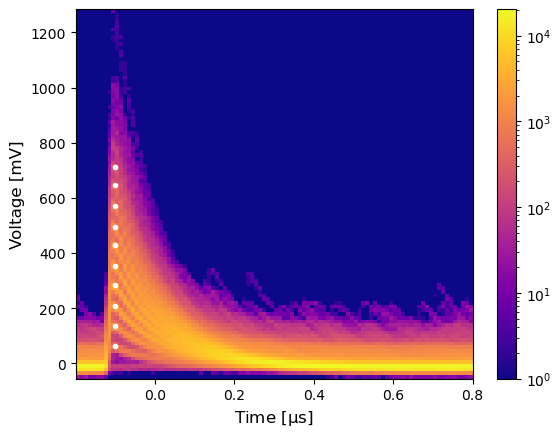

In [11]:
import matplotlib as mpl
import copy

fig, ax = plt.subplots(1,1)

my_cmap = copy.copy(plt.get_cmap('plasma')) # copy the default cmap
my_cmap.set_bad(my_cmap.colors[0]) #  set the color of invalid or masked values in the colormap


counts, xedges, yedges, im = ax.hist2d(time, signal, 
                                       bins=100, rasterized=True, 
#                                        range=((time.min(),time.max()), (-30,150)), 
#                                        range=((time.min(),time.max()), (voltage.min(),300)), 
#                                        range=((time.min(),time.max()), (100,500)), 
                                       cmap=my_cmap, norm=mpl.colors.LogNorm(vmin = 1))

for ii in range(1, n_pe + 1):
    ax.plot(-0.1, signal_pe[ii], 'ow', markersize = 3, label = '%s pe'%(ii))
    


ax.set_xlabel(r"Time [$\mathrm{\mu}$s]", size='larger')
ax.set_ylabel("Voltage [mV]", size='larger')

# ax.legend(loc = 'best')

fig.colorbar(im, ax = ax, orientation='vertical')
# fig.savefig("waveforms.pdf")

<p style="font-size: 17px; color: black;"> Set threshold to 80% of the single photo-electron

In [12]:
th = 0.8*signal_1pe # [mV] Height at which we measure the time difference between LED and Signal

<p style="font-size: 17px; color: black; font-weight: bold"> Waveform

<p style="font-size: 17px; color: black;"> Control frame

In [13]:
frame = 366

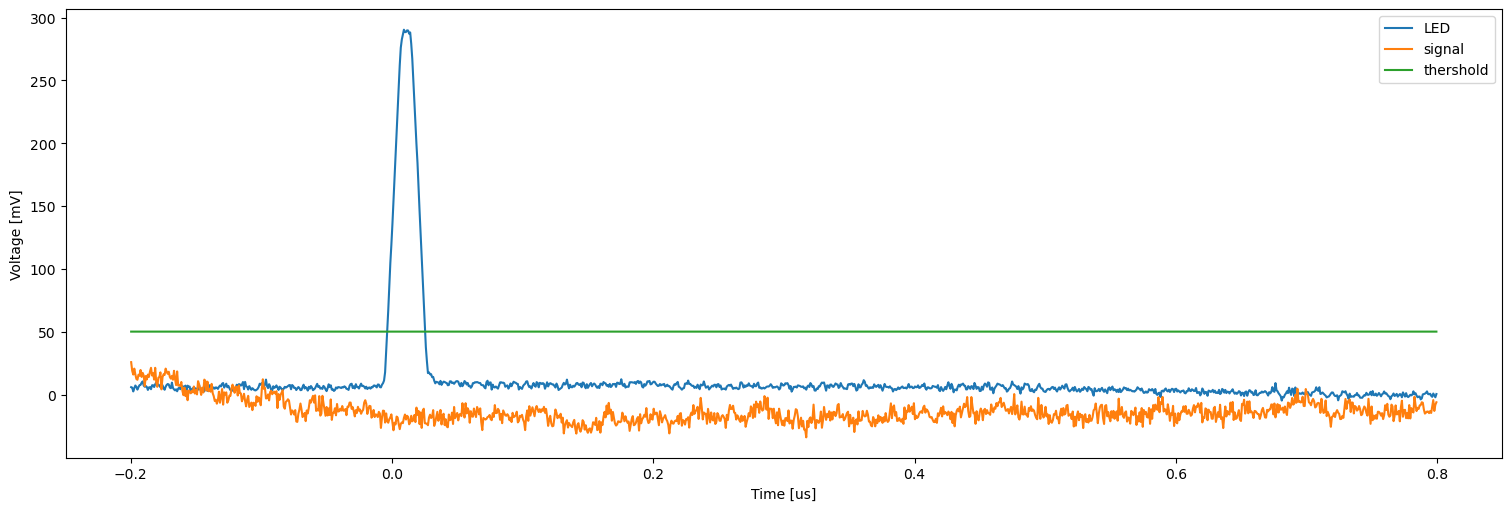

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

tt = time[frame*n_points: (frame + 1)*n_points].copy()  # [us]
ss = signal[frame*n_points: (frame + 1)*n_points].copy() # [mV]
ll = LED[frame*n_points: (frame + 1)*n_points].copy() # [mV]

ax.plot(tt, ll, label = 'LED')
ax.plot(tt, ss, label = 'signal')
ax.plot(tt, th*np.ones(len(tt)), label = 'thershold')

ax.set_ylabel('Voltage [mV]');
ax.set_xlabel('Time [us]');
ax.legend(loc = 'best')

<p style="font-size: 17px; color: black;"> Difference in time calculation for 1 frame

In [15]:
frame = int(n_frames/2)
frame = 1
frame = 100
frame = int(n_frames) - 1
frame = 500


dt = 0.12 us


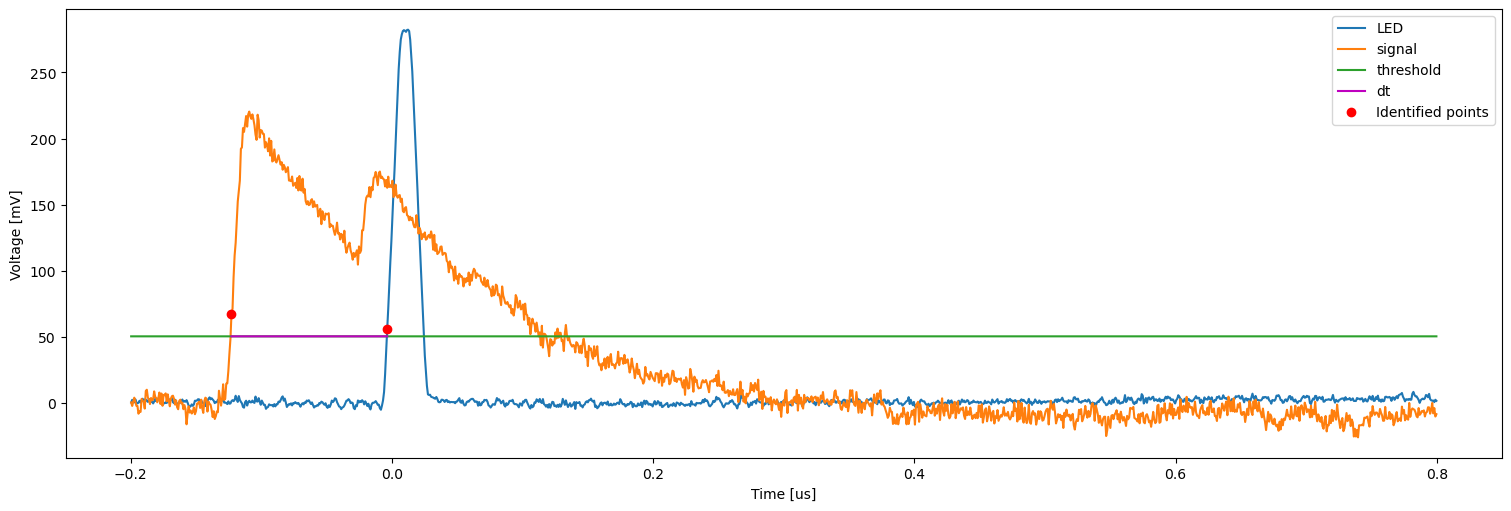

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

tt = time[frame*n_points: (frame + 1)*n_points].copy()  # [us]
ss = signal[frame*n_points: (frame + 1)*n_points].copy() # [mV]
ll = LED[frame*n_points: (frame + 1)*n_points].copy() # [mV]

t_ll_th = []
t_ss_th = []

v_ll_th = []
v_ss_th = []

mask_ll = (ll >= th)

if ss.max() < th: 
    print('no signal in this frame (%s)'%(frame))
    

mask_ss = (ss >= th)

t_ll_th.append(tt[mask_ll][0])
t_ss_th.append(tt[mask_ss][0])

v_ll_th.append(ll[mask_ll][0])
v_ss_th.append(ss[mask_ss][0])

dt = np.fabs(np.array(t_ss_th) - np.array(t_ll_th))
print('dt = %.2f us'%(dt))

ax.plot(tt, ll, label = 'LED')
ax.plot(tt, ss, label = 'signal')
ax.plot(tt, th*np.ones(len(tt)), label = 'threshold')

ax.plot(np.linspace(t_ll_th, t_ss_th, len(tt)), th*np.ones(len(tt)), '-m', label = 'dt')
ax.plot([t_ll_th, t_ss_th], [v_ll_th, v_ss_th], 'or', label = 'Identified points')

ax.set_ylabel('Voltage [mV]');
ax.set_xlabel('Time [us]');
ax.legend(loc = 'best')

<p style="font-size: 17px; color: black;"> Difference in time calculation for all frames

In [17]:
dt = []
s_peak = []

for frame in range(n_frames):
    
    tt = time[frame*n_points: (frame + 1)*n_points].copy()  # [us]
    ss = signal[frame*n_points: (frame + 1)*n_points].copy() # [mV]
    ll = LED[frame*n_points: (frame + 1)*n_points].copy() # [mV]

    t_ll_th = []
    t_ss_th = []

    v_ll_th = []
    v_ss_th = []
    
    mask_ll = (ll >= th)

    if ss.max() < th: 
        print('no signal in frame %s'%(frame))
        continue

    mask_ss = (ss >= th)

    t_ll_th.append(tt[mask_ll][0])
    t_ss_th.append(tt[mask_ss][0])

    v_ll_th.append(ll[mask_ll][0])
    v_ss_th.append(ss[mask_ss][0])


    s_peak.append(ss.max())
    dt.append(np.fabs(tt[mask_ll][0] - tt[mask_ss][0]))
    
    
dt = np.array(dt)
s_peak = np.array(s_peak)
    

no signal in frame 366
no signal in frame 739
no signal in frame 869
no signal in frame 1332
no signal in frame 1676
no signal in frame 2008
no signal in frame 2171
no signal in frame 2193
no signal in frame 2736
no signal in frame 3305


<p style="font-size: 17px; color: black;"> Last event plot and Peak distribution

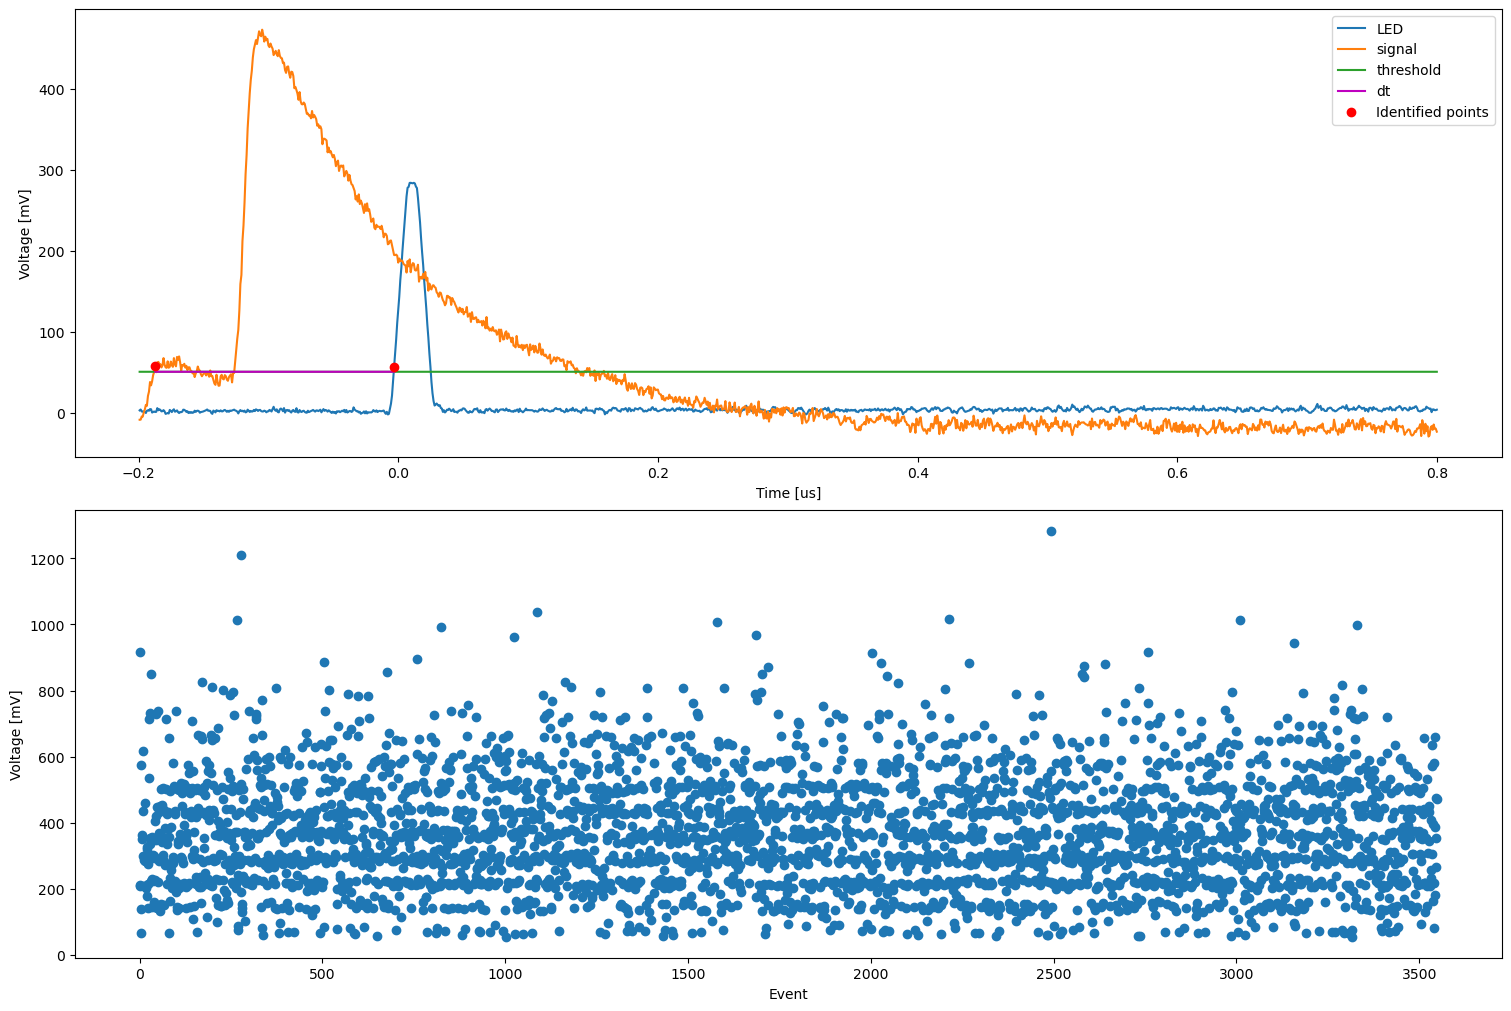

In [18]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10), constrained_layout=True)
# plot settings____________________________________________________________________________________

ax[0].plot(tt, ll, label = 'LED')
ax[0].plot(tt, ss, label = 'signal')
ax[0].plot(tt, th*np.ones(len(tt)), label = 'threshold')

ax[0].plot(np.linspace(t_ll_th, t_ss_th, len(tt)), th*np.ones(len(tt)), '-m', label = 'dt')
ax[0].plot([t_ll_th, t_ss_th], [v_ll_th, v_ss_th], 'or', label = 'Identified points')

ax[0].set_ylabel('Voltage [mV]');
ax[0].set_xlabel('Time [us]');

hand, labl = ax[0].get_legend_handles_labels()
hand, labl = np.array(hand), np.array(labl)
not_duplicated = ~pd.DataFrame(labl).duplicated()

ax[0].legend(hand[not_duplicated], labl[not_duplicated])
# ax.legend(loc = 'best')

ax[1].plot(s_peak, 'o')
ax[1].set_ylabel('Voltage [mV]');
ax[1].set_xlabel('Event');
# ax[1].set_xlim([7.2e-7, 7.8e-7])
# ax[1].set_ylim([s_peak.min(), 150])

<p style="font-size: 17px; color: black;"> Peak identification

In [28]:
dV = [] # [mV]

for i in range(0, n_pe+1):
    dV.append((signal_pe[i+1] + signal_pe[i])/2)
    
dV.append(s_peak.max())
    
mask_pe = []
for i in range(n_pe+1):
#     mask_pe.append(np.fabs(s_peak - signal_pe[i]) <= dV) # for fixed dV
    
    mask_pe.append(((s_peak > dV[i]) & (s_peak < dV[i+1])))
        

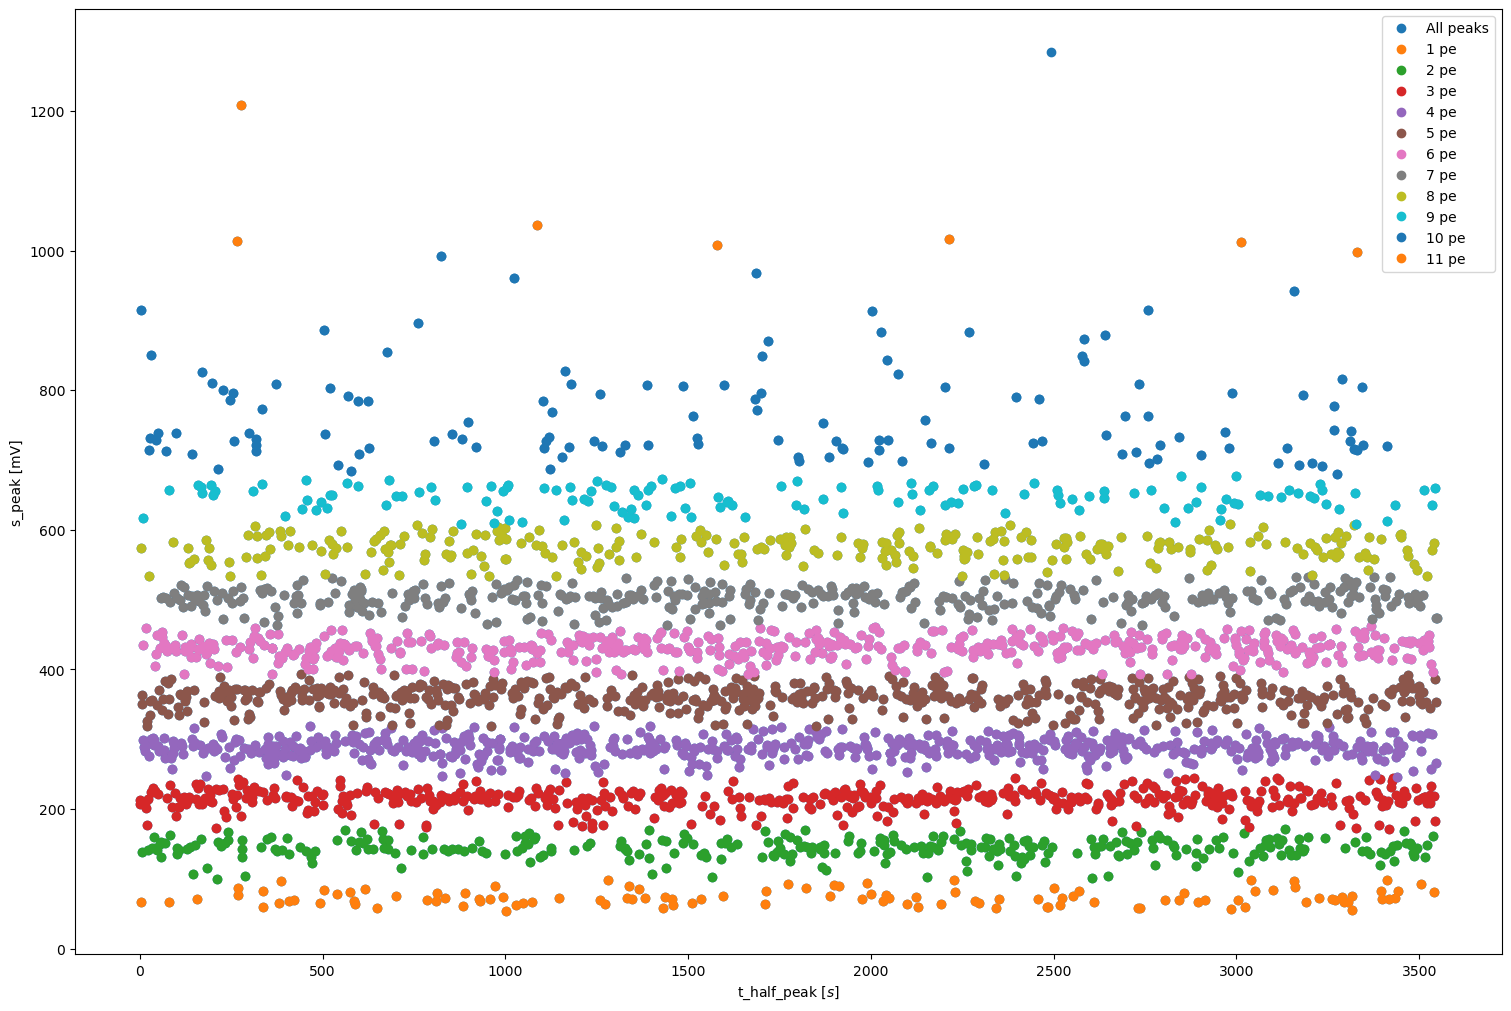

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (15, 10), constrained_layout=True)

#______________________plot settings________________________________________________________

x_ax = np.arange(len(s_peak))

ax.plot(x_ax, s_peak, 'o', label = 'All peaks')
for ii in range(len(mask_pe)):
    
    ax.plot(x_ax[mask_pe[ii]], s_peak[mask_pe[ii]], 'o', label = '%s pe'%(ii + 1))

ax.set_ylabel('s_peak [mV]');
ax.set_xlabel('t_half_peak [$s$]');

# ax.set_xlim([7.2e-7, 7.8e-7])
# ax.set_ylim([s_peak.min(), 150])
ax.legend(loc = 'best')


<p style="font-size: 17px; color: black;"> Time resolution calculation

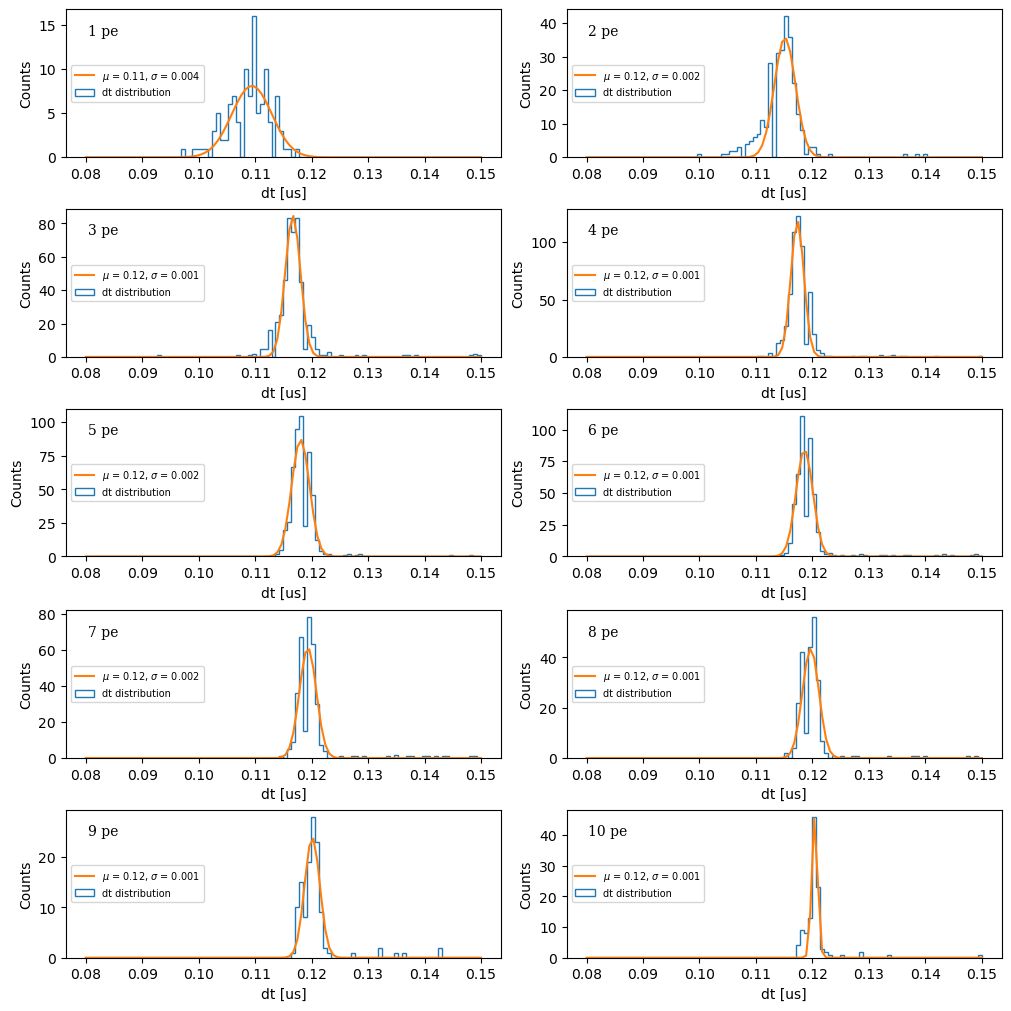

In [32]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10), constrained_layout=True)

n_row = 0

t_res = np.zeros(n_pe)

for pe in range(n_pe):
    
    n_col = pe%2
    
    events, bins, bars = ax[n_row, n_col].hist(dt[mask_pe[pe]], 100, 
                                     density=False, 
                                               range=(0.08, 0.15),
                                     label='dt distribution', 
                                     histtype='step')
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

    # gaussian fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 0.001]) 

    a, mu, sigma = popt
    best_fit_line = gauss(x_ax, a, mu, sigma)
    
    t_res[pe] = sigma

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.3f'%(mu, sigma))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('dt [us]')

    ax[n_row, n_col].legend(fontsize=7, loc='center left')
    
    n_row += pe%2
    

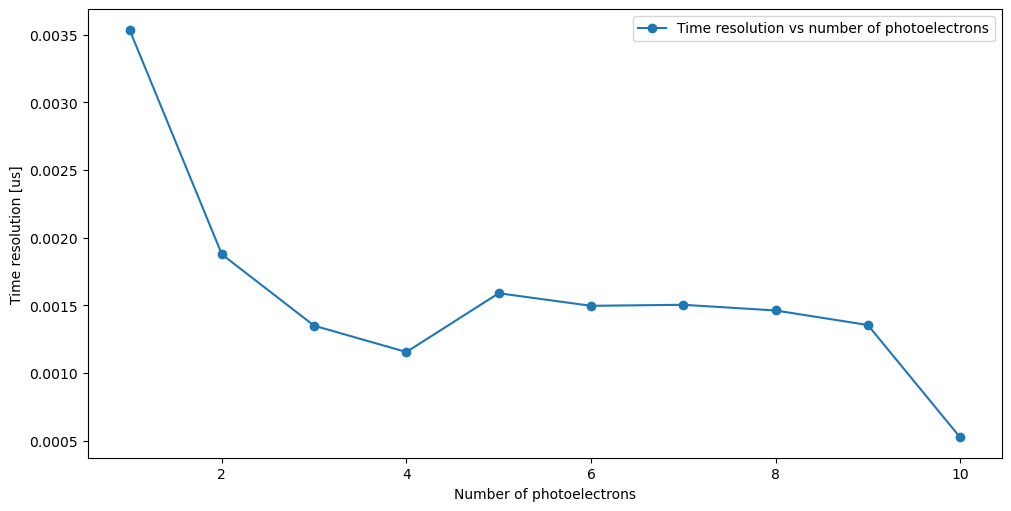

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

x_ax = np.arange(len(t_res)) + 1

ax.plot(x_ax, t_res, 'o-', label = 'Time resolution vs number of photoelectrons')

ax.set_ylabel('Time resolution [us]')
ax.set_xlabel('Number of photoelectrons')

ax.legend(loc = 'best')

<p style="font-size: 17px; color: black;"> Energy resolution calculation

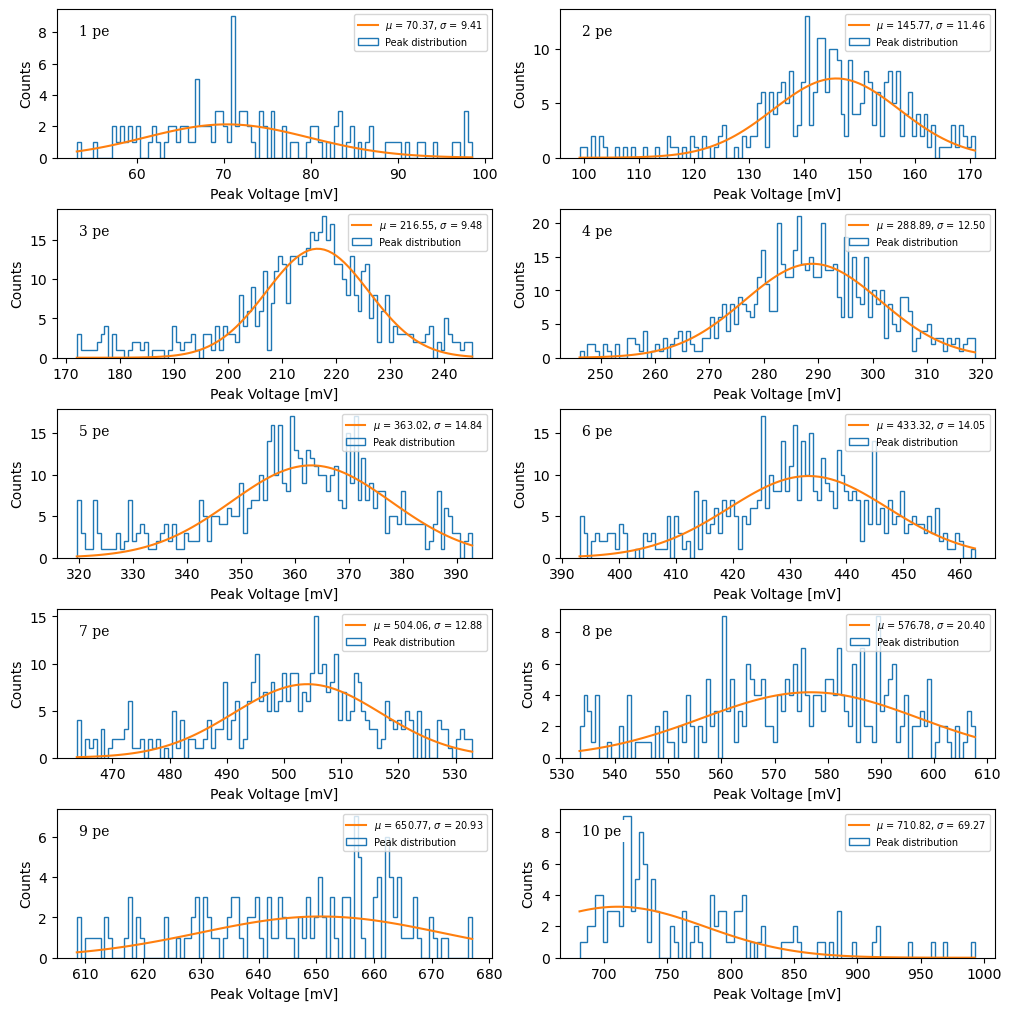

In [35]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10), constrained_layout=True)

n_row = 0

e_res = np.zeros(n_pe)

for pe in range(n_pe):
    
    n_col = pe%2
    
    events, bins, bars = ax[n_row, n_col].hist(s_peak[mask_pe[pe]], 100, 
                                     density=False, 
#                                                range=(0.08, 0.15),
                                     label='Peak distribution', 
                                     histtype='step')
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

#     # gaussian fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 30.]) 

    a, mu, sigma = popt
    best_fit_line = gauss(x_ax, a, mu, sigma)
    
    e_res[pe] = sigma

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu, sigma))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('Peak Voltage [mV]')

    ax[n_row, n_col].legend(fontsize=7, loc='best')
    
    n_row += pe%2
    

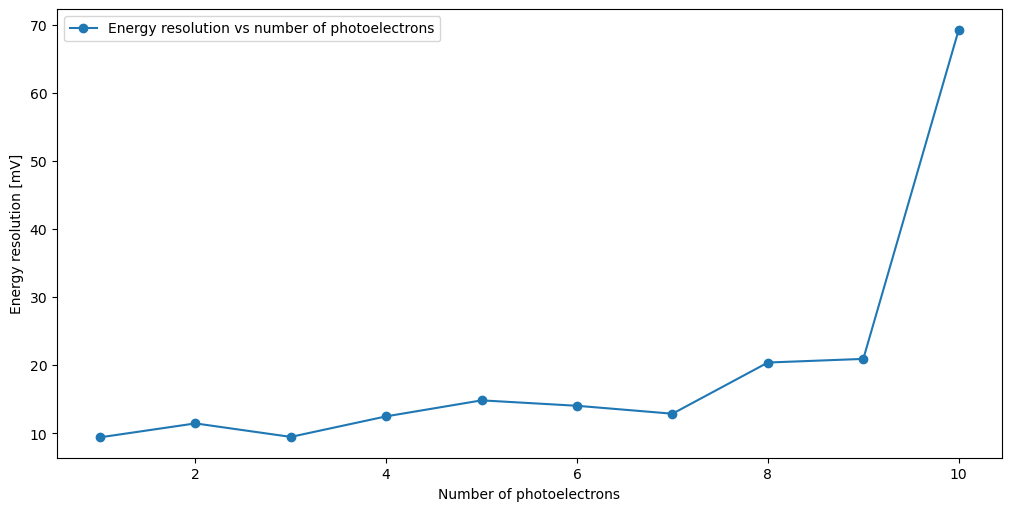

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

x_ax = np.arange(len(e_res)) + 1

ax.plot(x_ax, e_res, 'o-', label = 'Energy resolution vs number of photoelectrons')

ax.set_ylabel('Energy resolution [mV]')
ax.set_xlabel('Number of photoelectrons')

ax.legend(loc = 'best')